In [91]:
#CORE CONSTANTS
IMG_INDEX = 1 #Min is 0, Max is 799
BATCH = 64
EPOCHS = 50
L_RATE = 0.001

In [2]:
from datasets import load_dataset
#Installing datasets library to access CORD dataset

In [4]:
%matplotlib inline
#inline magic command to make sure all pictures are in line with each cell

#Installing libraries
print("INSTALLING LIBRARIES....")
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import matplotlib.patches as patches
print("LIBRARIES INSTALLED!")

INSTALLING LIBRARIES....
LIBRARIES INSTALLED!


In [5]:
print("DOWNLOADING CORD DATASET...")
cord_dataset = load_dataset("naver-clova-ix/cord-v2")
print("CORD DATASET DOWNLOADED!")
print("Cord dataset type: ", type(cord_dataset))

DOWNLOADING CORD DATASET...


Using custom data configuration naver-clova-ix--cord-v2-c97f979311033a44
Found cached dataset parquet (/Users/piriyan_karu/.cache/huggingface/datasets/naver-clova-ix___parquet/naver-clova-ix--cord-v2-c97f979311033a44/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

CORD DATASET DOWNLOADED!
Cord dataset type:  <class 'datasets.dataset_dict.DatasetDict'>


In [7]:
#Initialising train, val and test datasets
print("SEPARATING DATASET INTO TRAIN, VALIDATION AND TEST...")
train, val, test = cord_dataset["train"], cord_dataset["validation"], cord_dataset["test"]
print("DATASET SEPERATED!")

SEPARATING DATASET INTO TRAIN, VALIDATION AND TEST...
DATASET SEPERATED!


# Pre-processing data from training, validation and testing datasets
### Initially checking data format
### Seperating target data needed

In [8]:
#Seperating images
train_images = train['image']
train_labels = train['ground_truth']

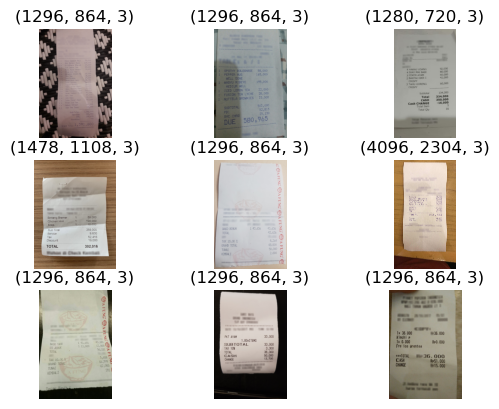

In [9]:
#plt.figure((10,10))
for i in range(9):
    img = np.array(train_images[i])
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(img.shape)
    plt.axis('off')

A label for training data when evaluated using **eval** function gives the following keys:
'gt_parse', 'meta', 'valid_line', 'roi', 'repeating_symbol', 'dontcare'

We do not need: 'roi', 'repeating_symbol' and 'dontcare

gt_parse: Tells us information that we do not need for the problem of region detection
meta: Tells us information such as width, height, id of image
valid_line: **IMPORTANT** for this problem as it gives us all the coordinates of each text point in image

In [33]:
"""
def keyRep(lables, key_str):
    print(key_str.upper() + ":")
    print(lables[key_str])
    print("************************************************")
    

keyRep(a_label, "gt_parse")
keyRep(a_label, "meta")
keyRep(a_label, "valid_line")
"""

'\ndef keyRep(lables, key_str):\n    print(key_str.upper() + ":")\n    print(lables[key_str])\n    print("************************************************")\n    \n\nkeyRep(a_label, "gt_parse")\nkeyRep(a_label, "meta")\nkeyRep(a_label, "valid_line")\n'

In [42]:
a_label['meta']['image_size']['width']

{'width': 864, 'height': 1296}

**CURRENT PROBLEM:** Detect dense regions in given receipt

In order to tackle this problem, we need to process the given coordinates into the following format for each image (min x1, min y1, max x3, max y3)

Each element of valid line has the following keys: words, category, group_id, sub_group_id

words: contains the coordinates
- Each element of words contain keys: quad, is_key, row_id, text
- quad: contains the actual coordinates
- text: contains the text at given coordinate

In [35]:
print("Defining function to retreive [x1, y1, x3, y3] coordinates of each datapoint")

def retreiveCoordinates(labels):
    coords = []
    vline = labels["valid_line"]
    for line in vline:
        words = line['words']
        for word in words:
            quad = word['quad']
            box = [quad['x1'], quad['y1'], quad['x3'], quad['y3']]
            coords.append(box)
    
    return coords

Defining function to retreive [x1, y1, x3, y3] coordinates of each datapoint


In [36]:
print("Defining function to get (min x1, min y1, max x3, max y3)")

def denseBoxCoord(label):
    coords = retreiveCoordinates(label)
    x1 = [coord[0] for coord in coords]
    y1 = [coord[1] for coord in coords]
    x3 = [coord[2] for coord in coords]
    y3 = [coord[3] for coord in coords]
    
    PAD = 20
    
    denseBox = [min(x1)-PAD, min(y1)-PAD, max(x3)+PAD, max(y3)+PAD]
    return denseBox

Defining function to get (min x1, min y1, max x3, max y3)


In [45]:
print("Defining a displaying function to display images with dense box on them")

def showDBox(img_index):
    a = train_images[img_index]
    a_label = eval(train_labels[img_index])
    width, height = a_label['meta']['image_size']['width'], a_label['meta']['image_size']['height']
    dBox_a = denseBoxCoord(a_label)
    fig, ax = plt.subplots()

    ax.imshow(a)
    x1 = dBox_a[0]
    y1 = dBox_a[1]
    x3 = dBox_a[2]
    y3 = dBox_a[3]
    rect = patches.Rectangle((x1, y1), (x3-x1), (y3-y1), linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

    plt.title("WxH: ({0},{1}) | {2}".format(width, height, dBox_a))
    plt.axis('off')
    plt.show()

Defining a displaying function to display images with dense box on them


In [58]:
print("Defining pre-process function for images")

def pre_process_images(images):
    new_images = [img_to_array(image.resize((224,224))) for image in images]
    new_images = np.array(new_images, dtype='float32') / 255.0
    return new_images

Defining pre-process function for images


In [59]:
print("Defining pre-process function for labels")

def pre_process_label(label):
    ev_lab = eval(label)
    width, height = a_label['meta']['image_size']['width'], a_label['meta']['image_size']['height']
    dBox = denseBoxCoord(ev_lab)
    dBox = [
        dBox[0] / width,
        dBox[1] / height,
        dBox[2] / width,
        dBox[3] / height
           ]
    
    return dBox

def pre_process_labels(labels):
    new_labels = []
    for label in labels:
        nLabel = pre_process_label(label)
        new_labels.append(nLabel)
    new_labels = np.array(new_labels)
    
    return new_labels

Defining pre-process function for labels


In [61]:
print("Pre-processing the datasets...")

tImages, tLabels = pre_process_images(train_images), pre_process_labels(train_labels)

print("Training Data: Processed")

vImages, vLabels = pre_process_images(val['image']), pre_process_labels(val['ground_truth'])

print("Validation Data: Processed")

Pre-processing the datasets...
Training Data: Processed
Validation Data: Processed


# Model

In [77]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [98]:
vgg16_model = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

vgg16_model.trainable = False

In [100]:
model = keras.models.Sequential([
    vgg16_model,
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(4, activation="sigmoid")
])

In [101]:
model.compile(optimizer=Adam(L_RATE),
              loss=tf.keras.losses.MeanSquaredError())

In [102]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_19 (Dense)            (None, 64)                1605696   
                                                                 
 dense_20 (Dense)            (None, 32)                2080      
                                                                 
 dense_21 (Dense)            (None, 16)                528       
                                                                 
 dense_22 (Dense)            (None, 4)                 68        
                                                                 
Total params: 16,323,060
Trainable params: 1,608,372
N

In [103]:
checkpoint = ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=True,
    monitor="val_loss",
    mode="min",
    save_best_only=True
) 

In [104]:
history = model.fit(tImages,tLabels,
                    validation_data = (vImages,vLabels),
                    batch_size = BATCH,
                    epochs = EPOCHS,
                    callbacks = [checkpoint]
                   )

Epoch 1/50
13/13 [==============================] - 97s 7s/step - loss: 0.1999 - val_loss: 0.1784
Epoch 2/50
13/13 [==============================] - 97s 7s/step - loss: 0.1641 - val_loss: 0.1664
Epoch 3/50
13/13 [==============================] - 97s 8s/step - loss: 0.1521 - val_loss: 0.1614
Epoch 4/50
13/13 [==============================] - 98s 8s/step - loss: 0.1438 - val_loss: 0.1579
Epoch 5/50
13/13 [==============================] - 98s 8s/step - loss: 0.1416 - val_loss: 0.1560
Epoch 6/50
13/13 [==============================] - 98s 8s/step - loss: 0.1364 - val_loss: 0.1545
Epoch 7/50
13/13 [==============================] - 98s 8s/step - loss: 0.1319 - val_loss: 0.1532
Epoch 8/50
13/13 [==============================] - 98s 8s/step - loss: 0.1295 - val_loss: 0.1527
Epoch 9/50
13/13 [==============================] - 97s 8s/step - loss: 0.1288 - val_loss: 0.1539
Epoch 10/50
13/13 [==============================] - 98s 8s/step - loss: 0.1272 - val_loss: 0.1527
Epoch 11/50
13/13 [

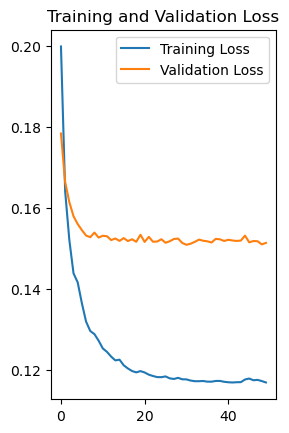

In [105]:

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [162]:
IDX = 50 # 0 - 99
def test_image(idx):
    test_data = test['image'][IDX]
    tl = eval(test['ground_truth'][IDX])
    w,h = tl['meta']['image_size']['width'], tl['meta']['image_size']['height']

    test_data = img_to_array(test_data.resize((224,224)))
    test_data = np.expand_dims(test_data, axis=0)
    
    preds = model.predict(test_data)
    
    (x1, y1, x3, y3) = preds[0]
    x1 = int(x1 * w)
    y1 = int(y1 * h)
    x3 = int(x3 * w)
    y3 = int(y3 * h)
    box = [x1,y1,x3,y3]
    
    pred_image = test['image'][IDX]
    
    fig, ax = plt.subplots()

    ax.imshow(pred_image)
    rect = patches.Rectangle((x1, y1), (x3-x1), (y3-y1), linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

    plt.title("WxH: ({0},{1}) | {2}".format(w, h, box))
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 133ms/step


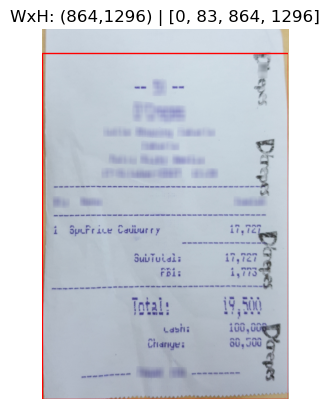

In [163]:
test_image(0)